# Unsupervised Learning Techniques

Although  most  of  the  applications  of  Machine  Learning  today  are  based  on  supervised learning (and as a result, this is where most of the investments go to), the vast majority  of  the  available  data  is  unlabeled:  we  have  the  input  features  X,  but  we  do not have the labels y. The computer scientist Yann LeCun famously said that “if intelligence  was  a  cake,  unsupervised  learning  would  be  the  cake,  supervised  learningwould  be  the  icing  on  the  cake,  and  reinforcement  learning  would  be  the  cherry  on the  cake.”  In  other  words,  there  is  a  huge  potential  in  unsupervised  learning  that  we have only barely started to sink our teeth into.

In this chapter we will look at:

- Clustering

    The goal is to group similar instances together into clusters. Clustering is a great tool  for  data  analysis,  customer  segmentation,  recommender  systems,  search engines,  image  segmentation,  semi-supervised  learning,  dimensionality  reduction, and more.
    
    
- Anomaly detection

    The  objective  is  to  learn  what  “normal”  data  looks  like,  and  then  use  that  to detect abnormal instances, such as defective items on a production line or a new trend in a time series.
    
    
- Density estimation

    This is the task of estimating the probability density function (PDF) of the random process  that  generated  the  dataset.  Density  estimation  is  commonly  used  for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.
    
    
Ready  for  some  cake?  We  will  start  with  clustering,  using  K-Means  and  DBSCAN, and then we will discuss Gaussian mixture models and see how they can be used for density estimation, clustering, and anomaly detection.

In [1]:
import numpy as np
np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Clustering

Clustering  is  the  task  of  identifying  similar  instances  and  assigningthem to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification,  clustering  is  an  unsupervised  task.  Consider  Figure  below:  on  the  left  is  the iris  dataset,  where  each  instance’s  species  (i.e.,  its  class)  is represented  with  a  different  marker.  It  is  a  labeled  dataset,  for  which  classification algorithms  such  as  Logistic  Regression,  SVMs,  or  Random  Forest  classifiers  are  well suited.  On  the  right  is  the  same  dataset,  but  without  the  labels,  so  you  cannot  use  a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.  That  said,  the  dataset  has  two  additional  features  (sepal  length  and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well (e.g., using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster).

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

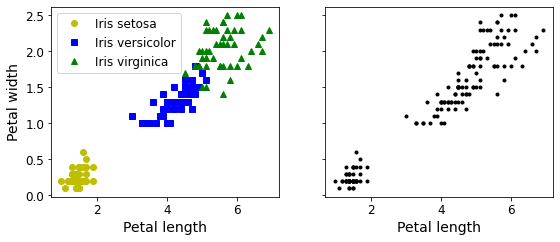

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping, we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

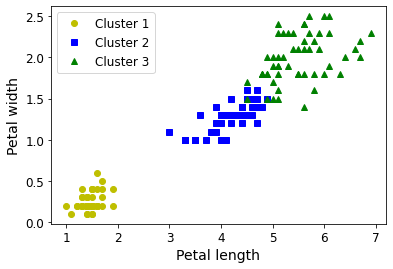

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

Let's look at the accuracy:

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

Clustering can be used in these fields:

- For customer segmentation
- For data analysis
- As a dimensionality reduction technique
- For anomaly detection (also called outlier detection)
- For semi-supervised learning
- For search engines
- To segment an image

There is no universal definition of what a cluster is: it really depends on the context, and  different  algorithms  will  capture  different  kinds  of  clusters.  Some  algorithms look  for  instances  centered  around  a  particular  point,  called  a  centroid.  Others  look for  continuous  regions  of  densely  packed  instances:  these  clusters  can  take  on  any shape. Some algorithms are hierarchical, looking for clusters of clusters. And the listgoes on.

In  this  section,  we  will  look  at  two  popular  clustering  algorithms,  K-Means  and DBSCAN,  and  explore  some  of  their  applications,  such  as  nonlinear  dimensionality reduction, semi-supervised learning, and anomaly detection.

### K-Means

Consider  the  unlabeled  dataset  represented  in  Figure  below:  you  can  clearly  see  five blobs of instances. The K-Means algorithm is a simple algorithm capable of clustering this  kind  of  dataset  very  quickly  and  efficiently,  often  in  just  a  few  iterations.  It  was proposed by Stuart Lloyd at Bell Labs in 1957 as a technique for pulse-code modulation, but it was only published outside of the company in 1982.1 In 1965, Edward W.Forgy had published virtually the same algorithm, so K-Means is sometimes referred to as Lloyd–Forgy.